In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from joblib import Parallel, delayed
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from sudoku import Sudoku
import tqdm
import pygame
import time
from random import randint

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SudokuDataset(Dataset):
    def __init__(self, data):
        self.puzzles = [torch.tensor(puzzle, dtype=torch.float).unsqueeze(0) for puzzle, _ in data]
        self.solutions = [torch.tensor(solution, dtype=torch.long) for _, solution in data]

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        return self.puzzles[idx], self.solutions[idx]

In [3]:
def swap_rows(grid1, grid2):
    """Swap two random rows within the same block for both puzzle and solution."""
    block = np.random.randint(0, 3)
    row1, row2 = np.random.choice(range(block * 3, (block + 1) * 3), size=2, replace=False)
    grid1[[row1, row2]] = grid1[[row2, row1]]
    grid2[[row1, row2]] = grid2[[row2, row1]]
    return grid1, grid2

def swap_columns(grid1, grid2):
    """Swap two random columns within the same block for both puzzle and solution."""
    block = np.random.randint(0, 3)
    col1, col2 = np.random.choice(range(block * 3, (block + 1) * 3), size=2, replace=False)
    grid1[:, [col1, col2]] = grid1[:, [col2, col1]]
    grid2[:, [col1, col2]] = grid2[:, [col2, col1]]
    return grid1, grid2

def rotate_grid(grid1, grid2):
    """Rotate both puzzle and solution by 90, 180, or 270 degrees."""
    k = np.random.choice([1, 2, 3])
    return np.rot90(grid1, k), np.rot90(grid2, k)

def augment_grid(puzzle, solution):
    """Apply random transformations to both puzzle and solution."""
    transformations = [swap_rows, swap_columns, rotate_grid]
    np.random.shuffle(transformations)
    for transform in transformations:
        puzzle, solution = transform(puzzle, solution)
    return puzzle, solution

In [4]:
def generate_single_sudoku():
    grid = Sudoku.from_dim(3)
    solution = np.array(grid.grid, dtype=np.int8)
    grid.remove_numbers(randint(10, 55))
    puzzle = np.array(grid.grid, dtype=np.int8)
    return puzzle, solution

def generate_dataset(num_samples, n_jobs=4):
    data = Parallel(n_jobs=n_jobs)(
        delayed(generate_single_sudoku)() for _ in tqdm.tqdm(range(num_samples))
    )
    puzzles, solutions = zip(*data)
    
    # Applichiamo data augmentation in modo consistente a puzzle e soluzione
    augmented_data = []
    for puzzle, solution in tqdm.tqdm(zip(puzzles, solutions), total=len(puzzles)):
        puzzle_aug, solution_aug = augment_grid(puzzle, solution)
        augmented_data.append((puzzle_aug, solution_aug))
    
    all_puzzles = np.concatenate((puzzles, [p[0] for p in augmented_data]))
    all_solutions = np.concatenate((solutions, [p[1] for p in augmented_data]))
    
    return list(zip(all_puzzles, all_solutions))

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.batch_norm1(self.conv1(x)))
        out = self.batch_norm2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class SudokuNet(nn.Module):
    def __init__(self):
        super(SudokuNet, self).__init__()

        # Layer Convoluzionali con Residual Blocks
        self.layer1 = ResidualBlock(1, 64)
        self.layer2 = ResidualBlock(64, 128)
        self.layer3 = ResidualBlock(128, 256)
        self.layer4 = ResidualBlock(256, 256)

        # Modulo LSTM
        self.lstm = nn.LSTM(input_size=256 * 9, hidden_size=512, num_layers=2, batch_first=True, dropout=0.3)

        # Fully connected layer finale
        self.fc1 = nn.Linear(512, 9 * 9 * 9)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Passaggio attraverso i blocchi residuali
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Reshape per adattare al LSTM (batch_size, seq_len, input_size)
        x = x.view(-1, 9, 256 * 9)  # Trattiamo ogni riga come una sequenza

        # Passaggio attraverso l'LSTM
        x, _ = self.lstm(x)  # output LSTM

        # Estrazione dell'ultima hidden state
        x = x[:, -1, :]  # Usiamo l'ultima uscita LSTM (hidden state)

        # Passaggio attraverso il fully connected layer
        x = self.dropout(x)
        x = self.fc1(x)

        # Output reshape in (batch_size, 9, 9, 9) per la previsione del Sudoku
        return x.view(-1, 9, 9, 9)

In [6]:
data = generate_dataset(num_samples=100000, n_jobs=8)
test_data = generate_dataset(num_samples=10, n_jobs=8)

100%|██████████| 10/10 [00:00<00:00, 3345.01it/s]


In [7]:
print(len(data), len(test_data))

200000 20


In [8]:
dataset = SudokuDataset(data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True)

In [9]:
test_dataset = SudokuDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)

In [10]:
model = SudokuNet().to('cuda')
criterion = nn.CrossEntropyLoss(ignore_index=-1).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scaler = GradScaler()

In [11]:
def validate(model, dataloader):
    model.eval()
    total_correct = 0
    total_numbers = 0
    
    with torch.no_grad():
        for puzzles, solutions in dataloader:
            puzzles, solutions = puzzles.to('cuda'), solutions.to('cuda')
            output = model(puzzles)
            output = output.view(-1, 9) 
            _, predicted = torch.max(output, 1)
            
            predicted = predicted.view(puzzles.size(0), 9, 9) + 1
            solutions = solutions.view(puzzles.size(0), 9, 9)
            
            correct = (predicted == solutions).sum().item()
            total_correct += correct
            total_numbers += puzzles.size(0) * 81
    
    accuracy = total_correct / total_numbers
    return accuracy

In [12]:
def earlyStopping(val_losses, patience, delta, num_epochs):
    count = patience
    if len(val_losses) < patience: # se non abbiamo ancora abbastanza epoche per fare confronti
        return False
    elif len(val_losses) == num_epochs - 1: # se siamo all'ultima epoca
        return False
    else:
        last_losses_sum = sum(val_losses[-patience:])
        last_losses_avg = last_losses_sum / patience
        for i in range(1, patience+1):
            if val_losses[-i] < last_losses_avg + delta/2 and val_losses[-i] > last_losses_avg - delta/2:
                count -= 1
    return count <= 0

In [13]:
avg_losses = []
accuracies = []

num_epochs = 30
for epoch in tqdm.tqdm(range(num_epochs), desc="Training", leave=False):
    model.train()
    losses = []
    for inputs, targets in dataloader:
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            outputs = outputs.view(-1, 9)
            targets = targets.view(-1) - 1
            loss = criterion(outputs, targets)
            
        losses.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
    scheduler.step()
    avg_losses.append(sum(losses) / len(losses))
    accuracy = validate(model, dataloader)
    accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_losses[-1]:.3f}, Validation Accuracy: {accuracy:.3f}')
    if earlyStopping(avg_losses, 5, 0.005, num_epochs) or accuracy > 0.99:
        print("Early stopping with accuracy: ", accuracy * 100, "%")
        pygame.mixer.init()
        for i in range(3):
            pygame.mixer.Sound("msg.mp3").play()
            time.sleep(2.5)
        pygame.mixer.quit()
        break

Training:   3%|▎         | 1/30 [01:13<35:34, 73.61s/it]

Epoch 1/30, Loss: 1.820, Validation Accuracy: 0.385


Training:   7%|▋         | 2/30 [02:26<34:16, 73.46s/it]

Epoch 2/30, Loss: 1.569, Validation Accuracy: 0.501


Training:  10%|█         | 3/30 [03:40<33:05, 73.52s/it]

Epoch 3/30, Loss: 1.357, Validation Accuracy: 0.671


Training:  13%|█▎        | 4/30 [04:54<31:52, 73.57s/it]

Epoch 4/30, Loss: 1.199, Validation Accuracy: 0.739


Training:  17%|█▋        | 5/30 [06:07<30:40, 73.62s/it]

Epoch 5/30, Loss: 1.108, Validation Accuracy: 0.773


Training:  20%|██        | 6/30 [07:21<29:28, 73.69s/it]

Epoch 6/30, Loss: 0.986, Validation Accuracy: 0.810


Training:  23%|██▎       | 7/30 [08:35<28:16, 73.77s/it]

Epoch 7/30, Loss: 0.863, Validation Accuracy: 0.846


Training:  27%|██▋       | 8/30 [09:49<27:04, 73.85s/it]

Epoch 8/30, Loss: 0.767, Validation Accuracy: 0.863


Training:  30%|███       | 9/30 [11:03<25:50, 73.86s/it]

Epoch 9/30, Loss: 0.696, Validation Accuracy: 0.879


Training:  33%|███▎      | 10/30 [12:17<24:37, 73.86s/it]

Epoch 10/30, Loss: 0.641, Validation Accuracy: 0.884


Training:  37%|███▋      | 11/30 [13:31<23:23, 73.87s/it]

Epoch 11/30, Loss: 0.569, Validation Accuracy: 0.904


Training:  40%|████      | 12/30 [14:45<22:09, 73.86s/it]

Epoch 12/30, Loss: 0.539, Validation Accuracy: 0.910


Training:  43%|████▎     | 13/30 [15:58<20:54, 73.82s/it]

Epoch 13/30, Loss: 0.517, Validation Accuracy: 0.915


Training:  47%|████▋     | 14/30 [17:12<19:40, 73.76s/it]

Epoch 14/30, Loss: 0.498, Validation Accuracy: 0.920


Training:  50%|█████     | 15/30 [18:26<18:25, 73.68s/it]

Epoch 15/30, Loss: 0.480, Validation Accuracy: 0.924


Training:  53%|█████▎    | 16/30 [19:39<17:10, 73.62s/it]

Epoch 16/30, Loss: 0.465, Validation Accuracy: 0.928


Training:  57%|█████▋    | 17/30 [20:52<15:56, 73.54s/it]

Epoch 17/30, Loss: 0.450, Validation Accuracy: 0.931


Training:  60%|██████    | 18/30 [22:06<14:41, 73.47s/it]

Epoch 18/30, Loss: 0.439, Validation Accuracy: 0.934


Training:  63%|██████▎   | 19/30 [23:19<13:27, 73.38s/it]

Epoch 19/30, Loss: 0.429, Validation Accuracy: 0.937


Training:  67%|██████▋   | 20/30 [24:32<12:12, 73.27s/it]

Epoch 20/30, Loss: 0.420, Validation Accuracy: 0.940


Training:  70%|███████   | 21/30 [25:45<10:58, 73.22s/it]

Epoch 21/30, Loss: 0.388, Validation Accuracy: 0.948


Training:  73%|███████▎  | 22/30 [26:58<09:45, 73.13s/it]

Epoch 22/30, Loss: 0.378, Validation Accuracy: 0.951


Training:  77%|███████▋  | 23/30 [28:11<08:31, 73.07s/it]

Epoch 23/30, Loss: 0.370, Validation Accuracy: 0.953


Training:  80%|████████  | 24/30 [29:24<07:17, 73.00s/it]

Epoch 24/30, Loss: 0.364, Validation Accuracy: 0.956


Training:  83%|████████▎ | 25/30 [30:37<06:05, 73.01s/it]

Epoch 25/30, Loss: 0.357, Validation Accuracy: 0.958


Training:  87%|████████▋ | 26/30 [31:50<04:51, 72.97s/it]

Epoch 26/30, Loss: 0.351, Validation Accuracy: 0.959


Training:  90%|█████████ | 27/30 [33:02<03:38, 72.97s/it]

Epoch 27/30, Loss: 0.345, Validation Accuracy: 0.962


Training:  93%|█████████▎| 28/30 [34:15<02:25, 72.97s/it]

Epoch 28/30, Loss: 0.339, Validation Accuracy: 0.962


Training:  97%|█████████▋| 29/30 [35:28<01:12, 72.97s/it]

Epoch 29/30, Loss: 0.333, Validation Accuracy: 0.965


Epoch 30/30, Loss: 0.327, Validation Accuracy: 0.967


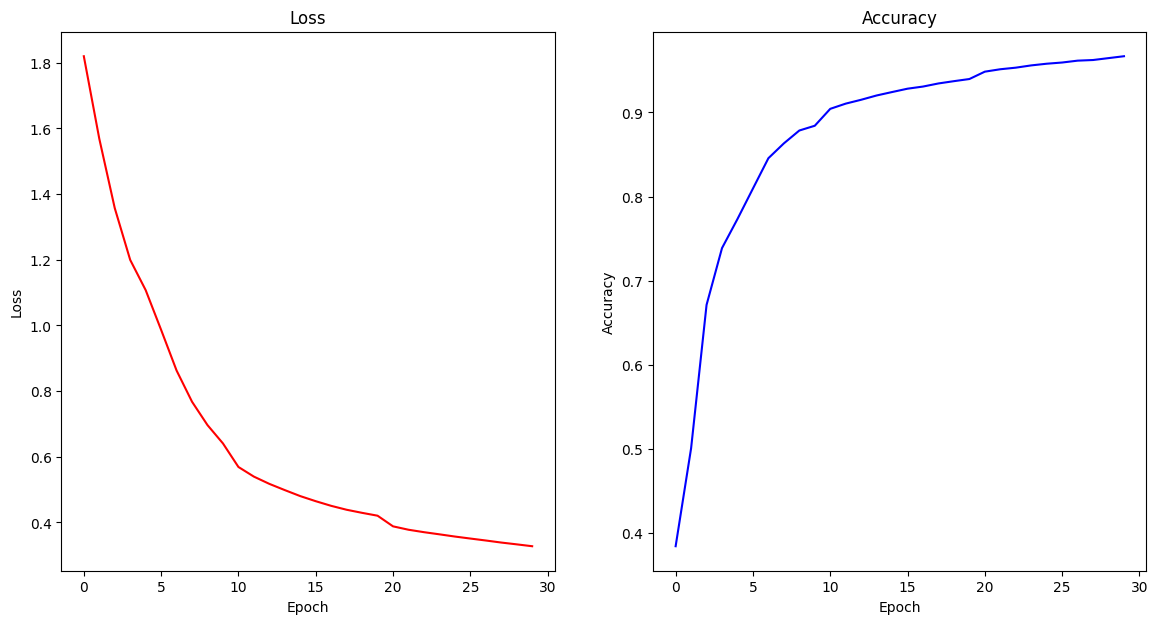

In [14]:
import matplotlib.pyplot as plt

plot_values = [avg_losses, accuracies]
plot_labels = ['Loss', 'Accuracy']


def plot_data(data, labels):
    subplots, ax = plt.subplots(1, len(data), figsize=(14, 7))
    # Loss
    ax[0].plot(data[0], '-r')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel(labels[0])
    ax[0].set_title(labels[0])
    # Accuracy
    ax[1].plot(data[1], '-b')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel(labels[1])
    ax[1].set_title(labels[1])

plot_data(plot_values, plot_labels)

In [18]:
# Test
model.eval()
count = 0

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 3)
        predicted = predicted + 1
        for j in range(inputs.size(0)):
            puzzle = inputs[j].cpu().numpy().reshape(9, 9).astype(int)
            solution = targets[j].cpu().numpy().reshape(9, 9).astype(int)
            prediction = predicted[j].cpu().numpy().reshape(9, 9).astype(int)
            incorrect = (prediction != solution)
            num_incorrect = np.sum(incorrect)
            if num_incorrect > 0:
                count += 1
                print(f'Puzzle {j + i * inputs.size(0)}:')
                print('Input Puzzle:')
                print(puzzle)
                print('Predicted Solution:')
                print(prediction)
                print('Correct Solution:')
                print(solution)
                print(f'Number of incorrect cells: {num_incorrect}')
                print('-' * 30)
            else:
                print("OK")
        # Per il test prendiamo solo il primo batch
        break

print(count)

OK
OK
OK
OK
OK
OK
OK
OK
Puzzle 8:
Input Puzzle:
[[0 3 5 7 2 4 8 6 1]
 [0 6 7 5 3 1 4 2 9]
 [2 4 0 6 9 8 7 5 3]
 [4 0 8 2 6 9 3 7 5]
 [7 5 6 8 4 3 0 1 2]
 [3 2 0 1 5 0 6 4 8]
 [6 7 2 3 8 5 1 9 4]
 [5 0 3 4 1 0 2 8 0]
 [0 0 4 9 7 0 5 0 6]]
Predicted Solution:
[[9 3 5 7 2 4 8 6 1]
 [8 6 7 5 3 1 4 2 9]
 [2 4 1 6 9 8 7 5 3]
 [4 1 8 2 6 9 3 7 5]
 [7 5 6 8 4 3 9 1 2]
 [3 2 9 1 5 7 6 4 8]
 [6 7 2 3 8 5 1 9 4]
 [5 9 3 4 1 6 2 8 7]
 [4 7 4 9 7 2 5 3 6]]
Correct Solution:
[[9 3 5 7 2 4 8 6 1]
 [8 6 7 5 3 1 4 2 9]
 [2 4 1 6 9 8 7 5 3]
 [4 1 8 2 6 9 3 7 5]
 [7 5 6 8 4 3 9 1 2]
 [3 2 9 1 5 7 6 4 8]
 [6 7 2 3 8 5 1 9 4]
 [5 9 3 4 1 6 2 8 7]
 [1 8 4 9 7 2 5 3 6]]
Number of incorrect cells: 2
------------------------------
OK
Puzzle 10:
Input Puzzle:
[[0 4 5 1 0 6 7 2 9]
 [2 8 0 5 7 9 3 6 4]
 [6 7 0 4 3 2 0 1 8]
 [0 2 0 3 4 5 0 0 6]
 [0 1 0 8 6 7 2 4 5]
 [4 5 6 0 9 1 8 7 3]
 [5 6 7 9 2 3 4 8 1]
 [8 0 2 6 1 4 9 0 7]
 [1 9 4 7 5 8 6 3 2]]
Predicted Solution:
[[3 4 5 1 8 6 7 2 9]
 [2 8 1 5 7 9 3 6 4]
 [6 